# Logistic Regression
## November 15th, 2022
### Overview: Using Logistic Regression for classification

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import statsmodels.api as sm
import time
from matplotlib import pyplot as plt

#### LogiReg
Creating a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points, including a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$, ma `predict_prob()` method that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$, and a `predict()` method that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [2]:
class LogiReg():
    """ input:
        y: nparray(n, 1) taking values only in {0,1}
        X: nparray(n, d)
    """
    
    def __init__(self, y, X):
        """
        Save y and X as attributes.
        """
        self.y = y
        self.X = X
    
    
    def fit(self):
        """
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        #for simplicity of notation, rename
        y = self.y
        X = self.X
        
        #function to be minimized
        fun = lambda B: sum([  y[i] * np.log(1 + np.exp(np.dot(-X[i],B))) + (1-y[i])*np.log(1 + np.exp(np.dot(X[i],B))) \
                            for i in range(len(y))])
        
        #minimize it
        self.beta = minimize(fun,np.ones(X.shape[1])).x
        
    def predict_prob(self, x_test):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """ 
        #pass through sigmoid
        return 1/(1  +  np.exp(np.dot(-x_test,self.beta)))
        
        
    def predict(self, x_test):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """
        #find all the probabilities
        probs = self.predict_prob(x_test)
        
        #if probability is > 0.5, set as 1; otherwise set as 0
        return np.where(probs>0.5,1,0)

## Implementation

Testing LogiReg classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Training classifier on $X$ and $y$. Generating a list of predicted labels using trained classifier and $X\_test$. Plotting $X\_test$ with a different color for each predicted label.

In [3]:
# this cell is simply creating the random data to be classified

data = np.column_stack(( 
    np.concatenate(( 
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) )), 
    # labels corresonding to each distribution
    np.concatenate(( np.zeros(100), np.ones(100) )) ))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)

In [4]:
#create solver, fit, and get predictions
LR = LogiReg(y,X)
LR.fit()
y_hat = LR.predict(X_test)

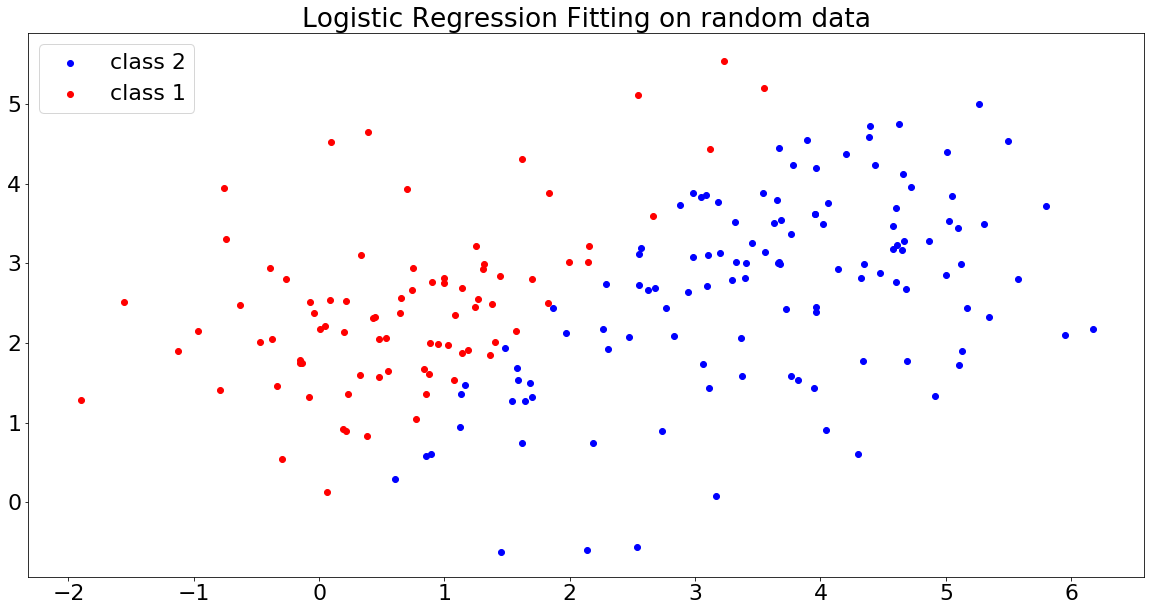

In [5]:
#could I have done this with a mask? yes. anyways find separate where the predictions are class 1 versus class 2
blues = np.argwhere(y_hat==1).flatten()
reds  = np.argwhere(y_hat==0).flatten()

#plot fitted data
plt.rcParams["figure.figsize"] = (20,10) #make plots big
plt.rcParams.update({'font.size': 22})
plt.scatter(X_test[blues][:,0],X_test[blues][:,1],color='blue',label='class 2')
plt.scatter(X_test[reds][:,0], X_test[reds][:,1] ,color='red',label='class 1')
plt.title('Logistic Regression Fitting on random data')
plt.legend()
plt.show()

#### Comparison

Using each of `LogiReg`, `statsmodels`, and `sklearn`, training a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, printing the accuracy scores for each trained model. Comparing the accuracies and training/testing time for all three classifiers.

In [6]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# X_test and y_test are generated similar to X and y
X_test = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20), np.eye(20), 100) ))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

#use these for the two that need an added constant
X2 = sm.add_constant(X)
X_test2 = sm.add_constant(X_test)

#fit LR, get prediction
LR2 = LogiReg(y,X2)
LR2.fit()
LR2_preds = LR2.predict(X_test2)

#fit statsmodel, get prediction
SM2 = sm.Logit(y,X2).fit_regularized(disp=0)
SM2_preds = SM2.predict(X_test2).astype(int)

#fit sklearn, get prediction
SKl = LogisticRegression(fit_intercept=True).fit(X,y)
SKl_preds = SKl.predict(X_test)

/home/zane/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [7]:
print('LogiReg score =',np.mean(LR2_preds==y_test))
print('statsmodels score =',np.mean(SM2_preds==y_test))
print('sklearn score =',np.mean(SKl_preds==y_test))

LogiReg score = 0.91
statsmodels score = 0.935
sklearn score = 0.945


## Implementation

Importing the Iris Dataset, train-test splitting on only the first two columns of the data with `test_size=0.4`. Training a multinomial logistic regression model using the training data with an added constant feature, and generating prediction labels for the test data.

Plotting the test data by color using prediction labels.

In [8]:
#load in the iris data
iris_x, iris_y = datasets.load_iris(return_X_y=True)
#only looking at the first two columns of x
iris_x_tosplit = iris_x[:,:2]
#split
x_train, x_test, y_train, y_test = train_test_split(iris_x_tosplit,iris_y,test_size=0.4)

In [9]:
#create sklearn model, fit, and predict
model = LogisticRegression(multi_class='multinomial',fit_intercept=True,solver='lbfgs').fit(x_train, y_train) 
y_hat = model.predict(x_test)

In [10]:
#separate each predicted class
predict_a = x_test[np.argwhere(y_hat==0).flatten()]
predict_b = x_test[np.argwhere(y_hat==1).flatten()]
predict_c = x_test[np.argwhere(y_hat==2).flatten()]

#also separate each true class
actual_a = x_test[np.argwhere(y_test==0).flatten()]
actual_b = x_test[np.argwhere(y_test==1).flatten()]
actual_c = x_test[np.argwhere(y_test==2).flatten()]

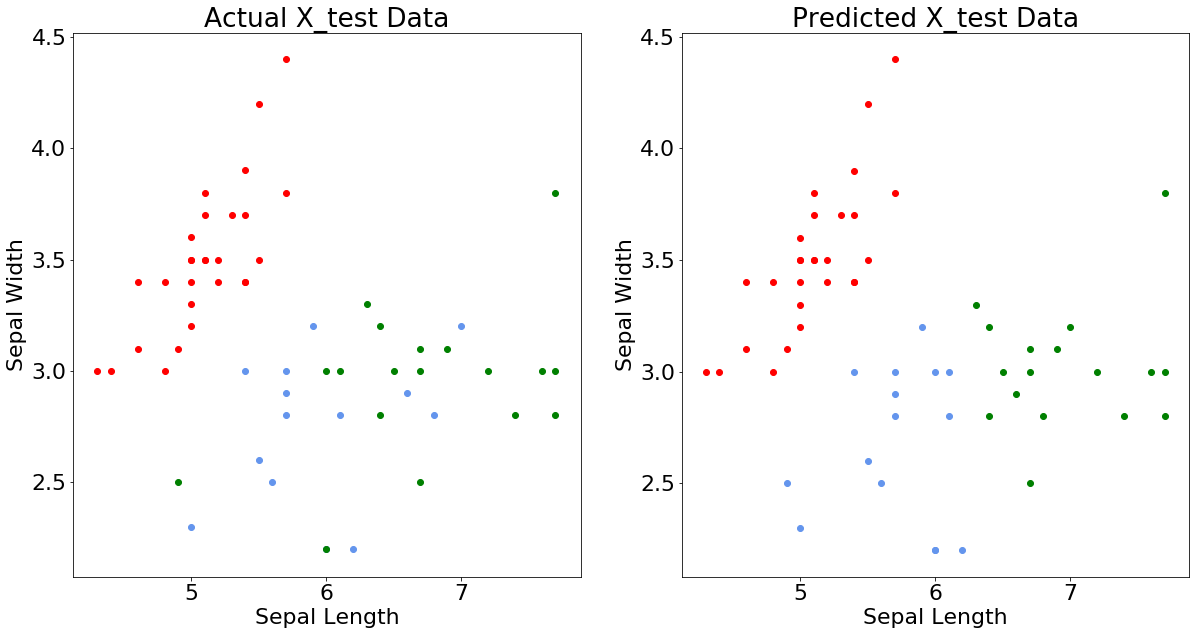

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2)

#plot the actual data
ax[0].scatter(actual_a[:,0],actual_a[:,1],color='red')
ax[0].scatter(actual_b[:,0],actual_b[:,1],color='cornflowerblue')
ax[0].scatter(actual_c[:,0],actual_c[:,1],color='green')
ax[0].set_title('Actual X_test Data')
ax[0].set_xlabel('Sepal Length')
ax[0].set_ylabel('Sepal Width')

#plot the predicted data
ax[1].scatter(predict_a[:,0],predict_a[:,1],color='red')
ax[1].scatter(predict_b[:,0],predict_b[:,1],color='cornflowerblue')
ax[1].scatter(predict_c[:,0],predict_c[:,1],color='green')
ax[1].set_title('Predicted X_test Data')
ax[1].set_xlabel('Sepal Length')
ax[1].set_ylabel('Sepal Width')

plt.show()